# Setup

## Stable Diffusion
https://www.nbshare.io/notebook/481422769/Install-and-Run-Stable-Diffusion-2-on-Ubuntu/

also do `pip install accelerate`

## FastChat

- install `pip install fschat`
- serve from 3 terminals
    - `python3 -m fastchat.serve.controller`
    - `CUDA_VISIBLE_DEVICES=0 python3 -m fastchat.serve.model_worker --model-path lmsys/fastchat-t5-3b-v1.0`
    - `python3 -m fastchat.serve.openai_api_server --host localhost --port 8000`

- use LangChain integration https://github.com/lm-sys/FastChat/blob/main/docs/langchain_integration.md
    - `pip install langchain`
    - `pip install openai`

# Run this notebook

LD_LIBRARY_PATH=/usr/lib/x86_64-linux-gnu/:/home/chrisfajardo2/HackathonMay2023/venv/lib/python3.10/site-packages/nvidia/cuda_runtime/lib OPENAI_API_BASE=http://localhost:8000/v1 OPENAI_API_KEY=EMPTY python3 -m jupyter notebook

# Notes

- Want app to run locally with Puget
- Need free LLM
    - https://github.com/eugeneyan/open-llms
    - Chose FastChat as it came with a server that compatible with LangChain
- Need memory
    - Use LangChain
    - Use StableDiffusion img2img

# TODO

- dockerize
- add captioning
- selection
- refine prompts
- UI
- PDF export
- WhisperAI

In [1]:
import torch
from diffusers import DiffusionPipeline, StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp

from langchain.memory import ConversationBufferMemory, ConversationSummaryBufferMemory
from langchain import OpenAI, LLMChain, PromptTemplate

In [5]:
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
pipe = pipe.to("cuda:1")
pipe.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
# Workaround for not accepting attention shape using VAE for Flash Attention
pipe.vae.enable_xformers_memory_efficient_attention(attention_op=None)
pipe.set_use_memory_efficient_attention_xformers(True)

pipe_im = StableDiffusionImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
pipe_im = pipe_im.to("cuda:1")
pipe_im.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
# Workaround for not accepting attention shape using VAE for Flash Attention
pipe_im.vae.enable_xformers_memory_efficient_attention(attention_op=None)
pipe_im.set_use_memory_efficient_attention_xformers(True)

fastchat_model = OpenAI(
    model="fastchat-t5-3b-v1.0",
    openai_api_base="http://localhost:8000/v1",
    openai_api_key="EMPTY"
)

In [25]:
def generate_image_desc(human_input):
    image_desc = llm_chain.predict(human_input=human_input)
    image_desc = image_desc.partition('Image: ')[2]
    return image_desc

def generate_image(human_input, image_input=None):
    if image_input:
        return pipe_im(
            prompt=f"cartoon: {human_input}",
            image = image,
            num_inference_steps=50,
            guidance_scale=0.25
        ).images[0]
    else:
        return pipe(
            prompt=f"cartoon: {human_input}",
            num_inference_steps=50,
            height=480,
            width=640
        ).images[0]

In [31]:
image = None

template = """
You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Please respond with one image generation prompt suggestion to match that section of the story, keeping in mind the previous lines.
It should have a cartoon style. It should have less than 50 words.
Respond in the format "Image: "

{chat_history}
Human: {human_input}
Chatbot:"""

prompt = PromptTemplate(
    input_variables=["chat_history", "human_input"], 
    template=template
)
memory = ConversationBufferMemory(memory_key="chat_history")

llm_chain = LLMChain(
    llm=fastchat_model, 
    prompt=prompt, 
    verbose=True, 
    memory=memory,
)

In [32]:
image_desc = generate_image_desc("""
Little Blue Truck came down the road. 'Beep!' said Blue to the big green toad.
""")
print(image_desc)



> Entering new LLMChain chain...
Prompt after formatting:

You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Please respond with one image generation prompt suggestion to match that section of the story, keeping in mind the previous lines.
It should have a cartoon style. It should have less than 50 words.
Respond in the format "Image: "


Human: 
Little Blue Truck came down the road. 'Beep!' said Blue to the big green toad.

Chatbot:

> Finished chain.
Little Blue Truck with a big green toad sitting in the front seat. Blue is holding a big blue sign that says "Beep!" and the toad is looking at it with a curious expression.



  0%|          | 0/50 [00:00<?, ?it/s]

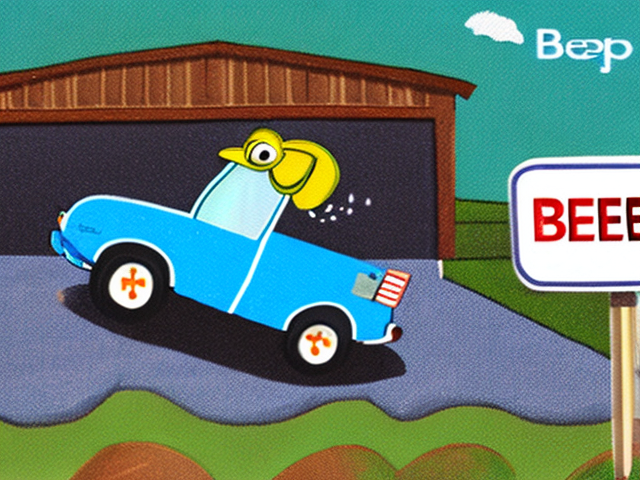

In [33]:
image = generate_image(image_desc, image)
image


In [34]:
image_desc = generate_image_desc("""
Toad said "Croak!" and winked an eye as the Little Blue Trunk went rolling by."
""")
image_desc



> Entering new LLMChain chain...
Prompt after formatting:

You are a chatbot having a conversation with a human. 
The human is reading a children's theme story to you one section at a time.
Please respond with one image generation prompt suggestion to match that section of the story, keeping in mind the previous lines.
It should have a cartoon style. It should have less than 50 words.
Respond in the format "Image: "

Human: 
Little Blue Truck came down the road. 'Beep!' said Blue to the big green toad.

AI: Image: Little Blue Truck with a big green toad sitting in the front seat. Blue is holding a big blue sign that says "Beep!" and the toad is looking at it with a curious expression.

Human: 
Toad said "Croak!" and winked an eye as the Little Blue Trunk went rolling by."

Chatbot:

> Finished chain.


'Toad winking his eye as the Little Blue Trunk rolls by with a big smile on his face. He is sitting on the ground next to the truck and is looking at it with a curious expression.\n'

  0%|          | 0/40 [00:00<?, ?it/s]

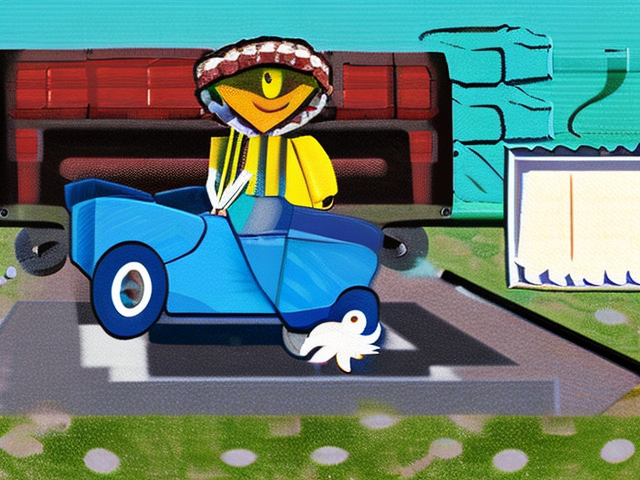

In [35]:
image = generate_image(image_desc, image)
image

In [18]:
pipe_im?